## Q: How does the forecast vary by region?

* I look at one year of data: 2023/07/01 to 2024/07/01
* There are 88 different regions.
* I filter down to my favourite 9 regions:
```
['CAISO_NORTH',
 'SPP_TX',
 'ERCOT_EASTTX',
 'FPL',
 'SOCO',
 'PJM_CHICAGO',
 'LDWP',
 'PJM_DC',
 'NYISO_NYC']
```
These are the 9 from `.regions_importance.ipynb` with `PSCO` replaced by `SPP_TX` on Henry's suggestion

# Results:

* All regions have daily periodicity as the main effect
* Some regions sometimes have the MOER dropping to near zero during some times 

In [43]:
%reload_ext autoreload
%autoreload 2

import sys

sys.path.append("../../")
from load_data import get_historical

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


regions = [
    "CAISO_NORTH",
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "LDWP",
    "PJM_DC",
    "NYISO_NYC",
]
start = "2023-07-01 00:00Z"
end = "2024-07-01 00:00Z"

In [44]:
# load or get from cache:
cache_path = "../../cache/historical_moer_9_regions_20230701_20240701.pkl"
if os.path.exists(cache_path):
    df = pd.read_pickle(cache_path)
else:
    df = get_historical(regions, start, end)
    df.to_pickle("../../cache/historical_moer_9_regions_20230701_20240701.pkl")

# Plot forecast time series

In [75]:
def plot_time_series(df):
    start = df.index.min().strftime("%Y/%m/%d")
    end = df.index.max().strftime("%Y/%m/%d")

    fig, axs = plt.subplots(3, 3, figsize=(12, 12), sharey=True)
    fig.suptitle(
        f"Historical MOER from {start} to {end} for the 9 regions containing major cities\ny-axes are MOER (CO2 lbs/MWh)"
    )
    for i, ax in enumerate(axs.flatten()):
        region = df.columns[i]
        df[region].plot(ax=ax, grid=True)
        ax.set_title(region)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

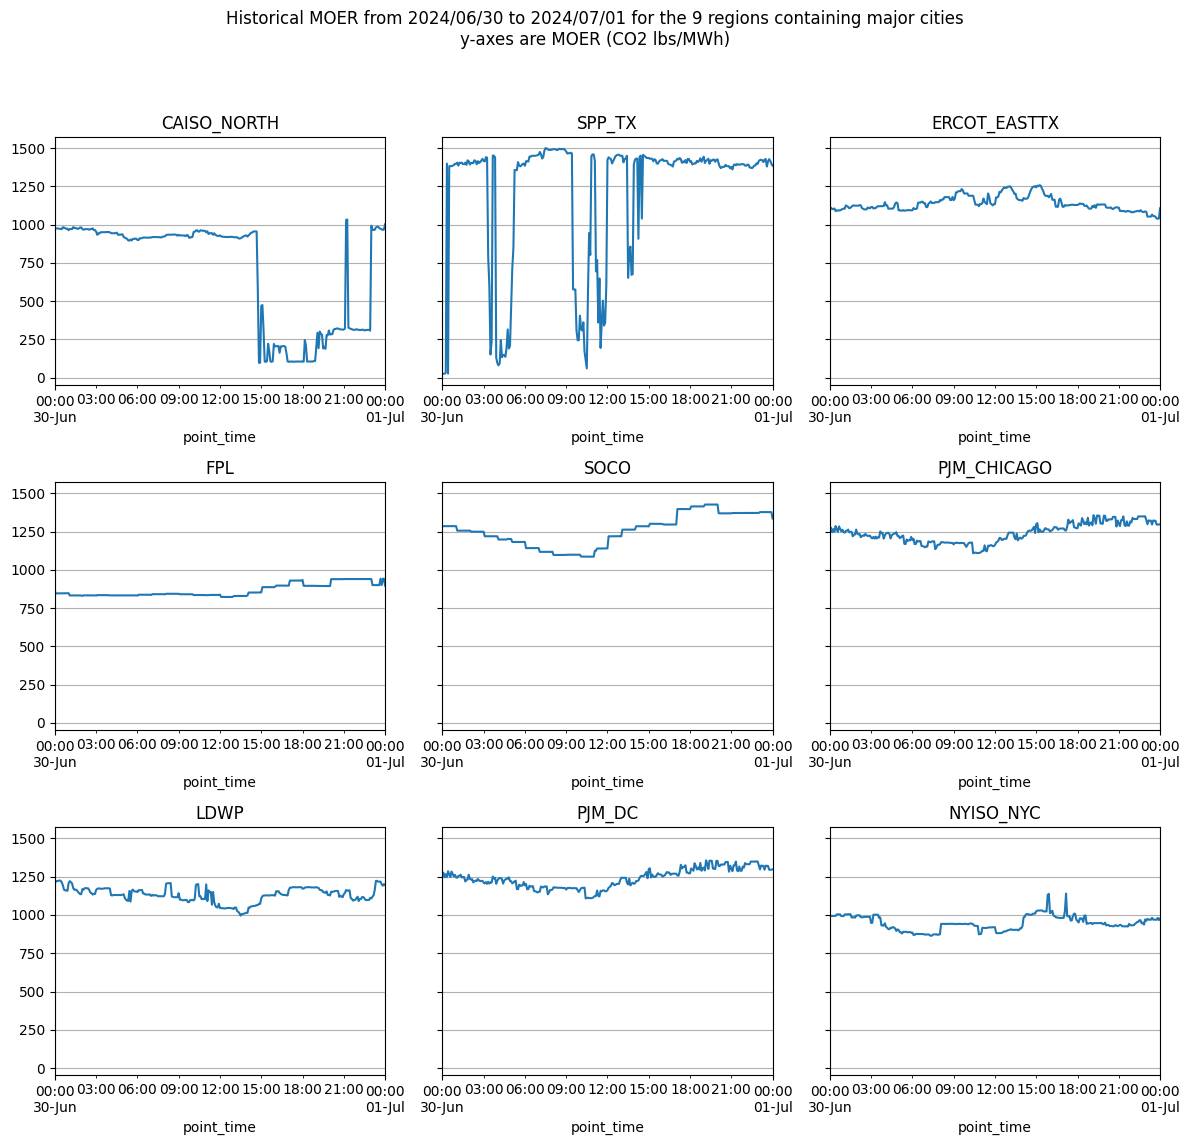

In [79]:
# one day
plot_time_series(df.loc["2024-06-30":"2024-07-01"])

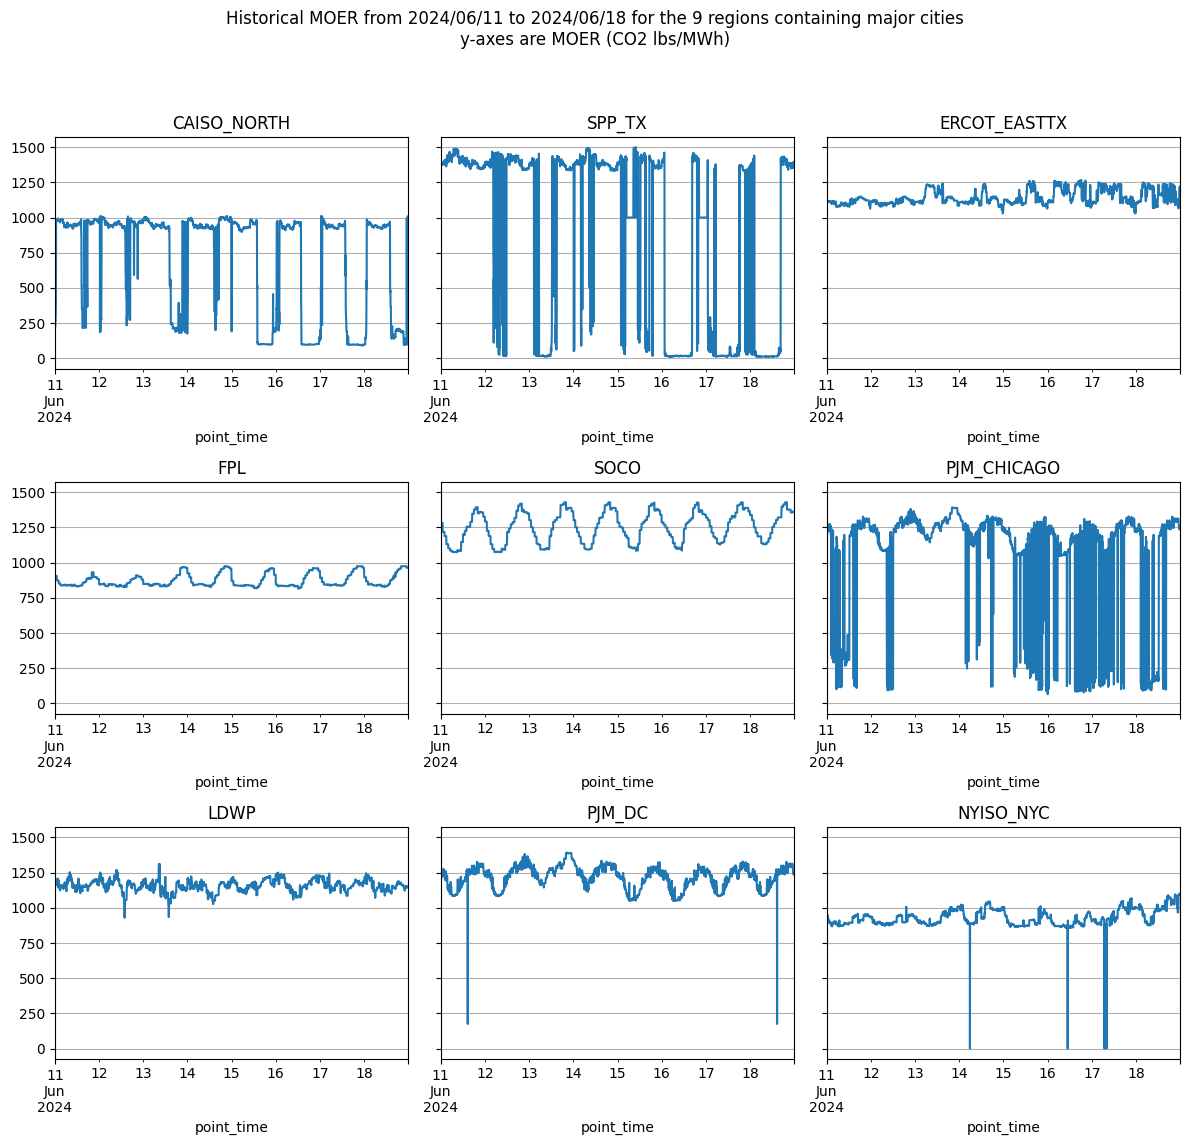

In [80]:
# one week
plot_time_series(df.loc["2024-06-11":"2024-06-18"])

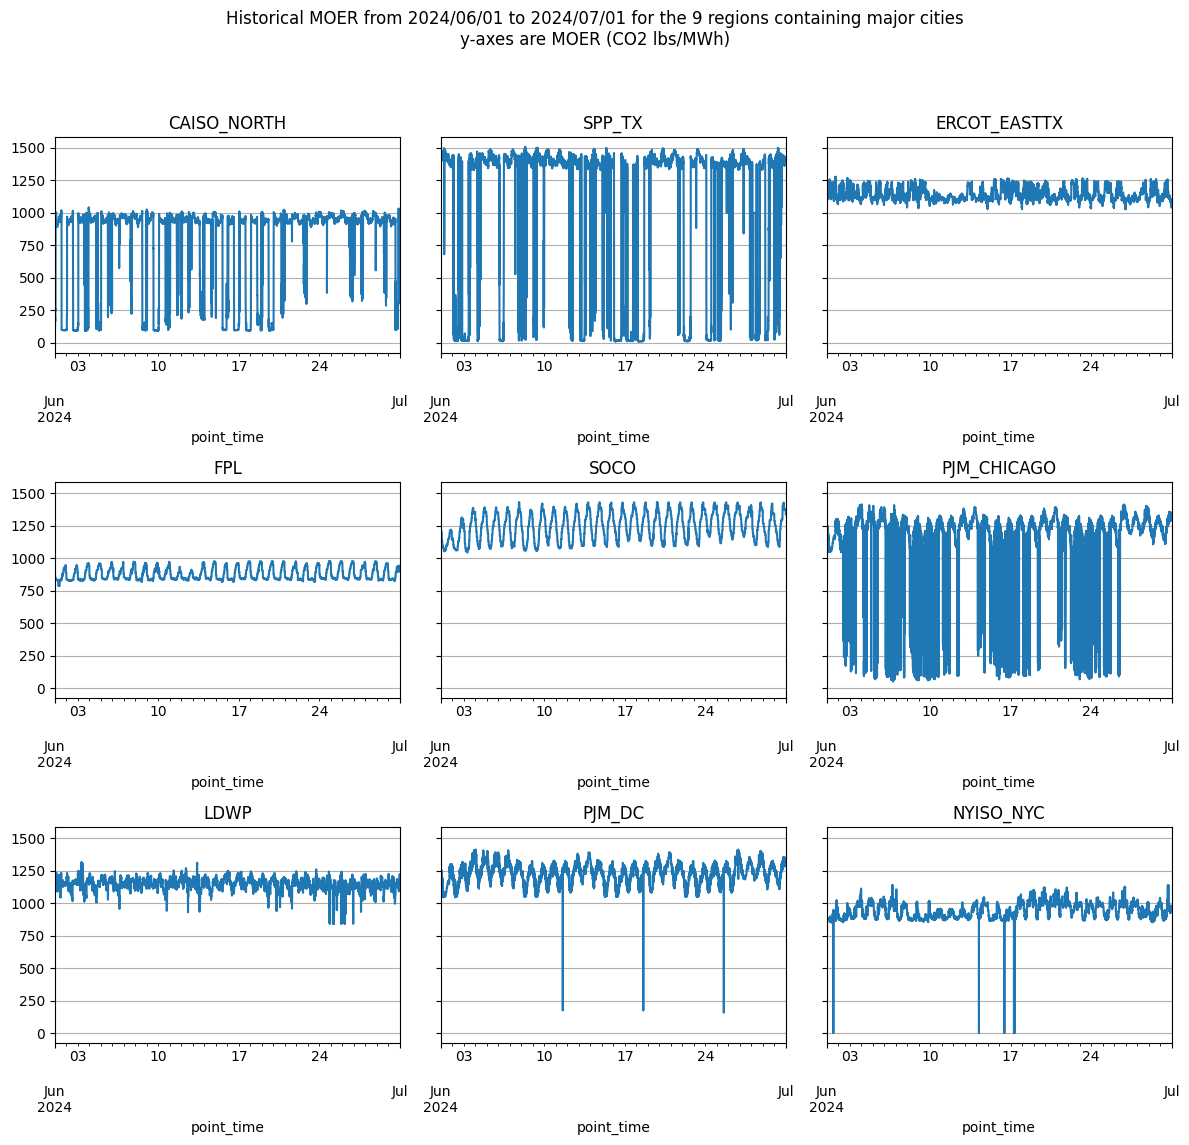

In [81]:
# one month
plot_time_series(df.loc["2024-06-01":"2024-07-01"])

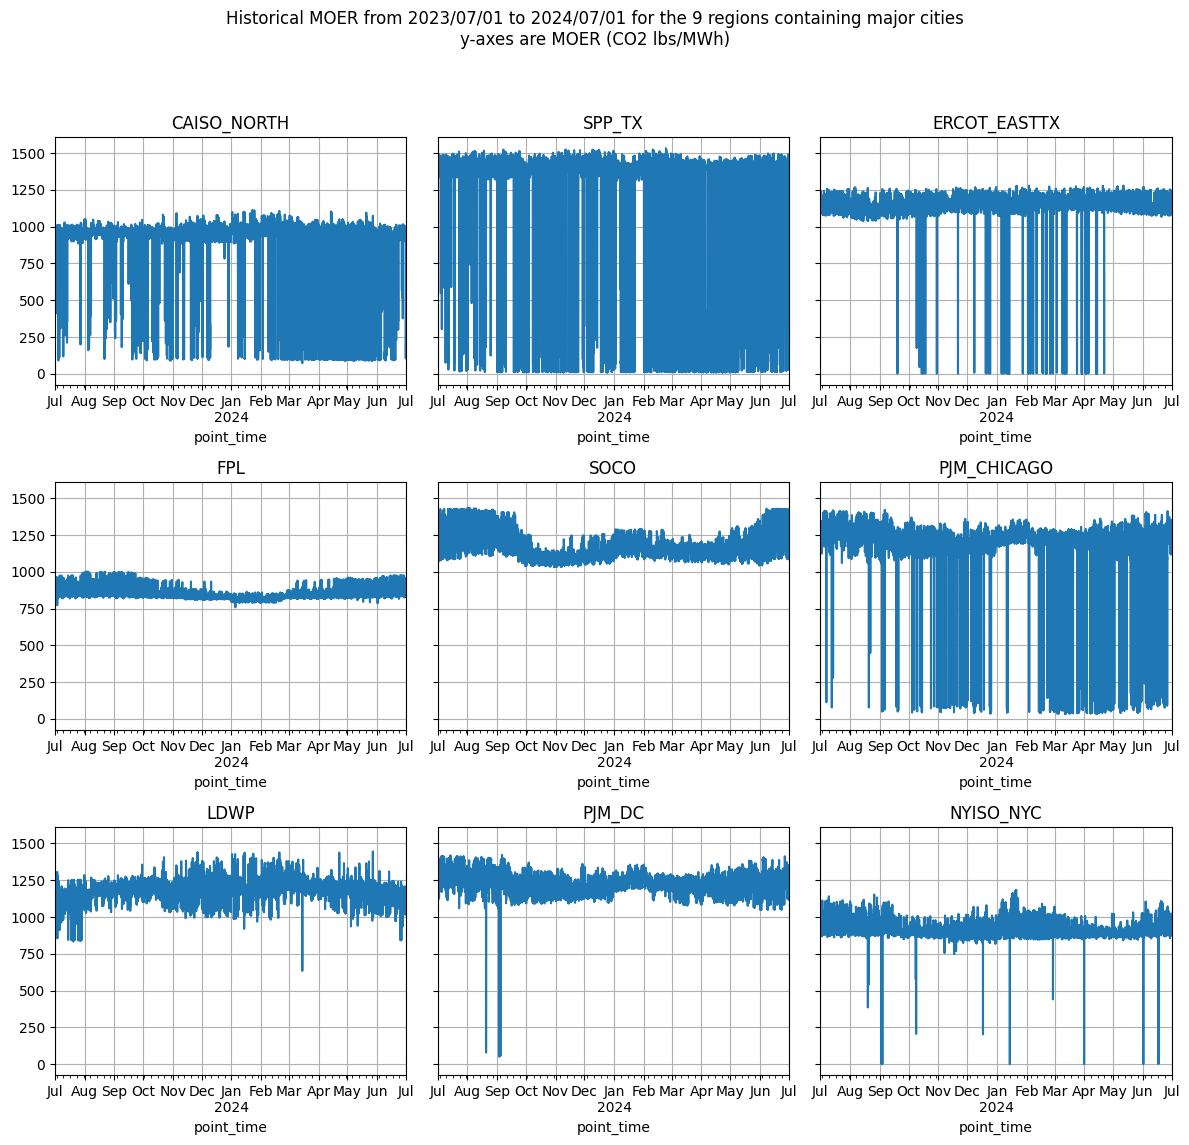

In [83]:
# one year, subsampled to once per hour
# rather than once per five minutes
plot_time_series(df.loc[::12])

## Plot histograms

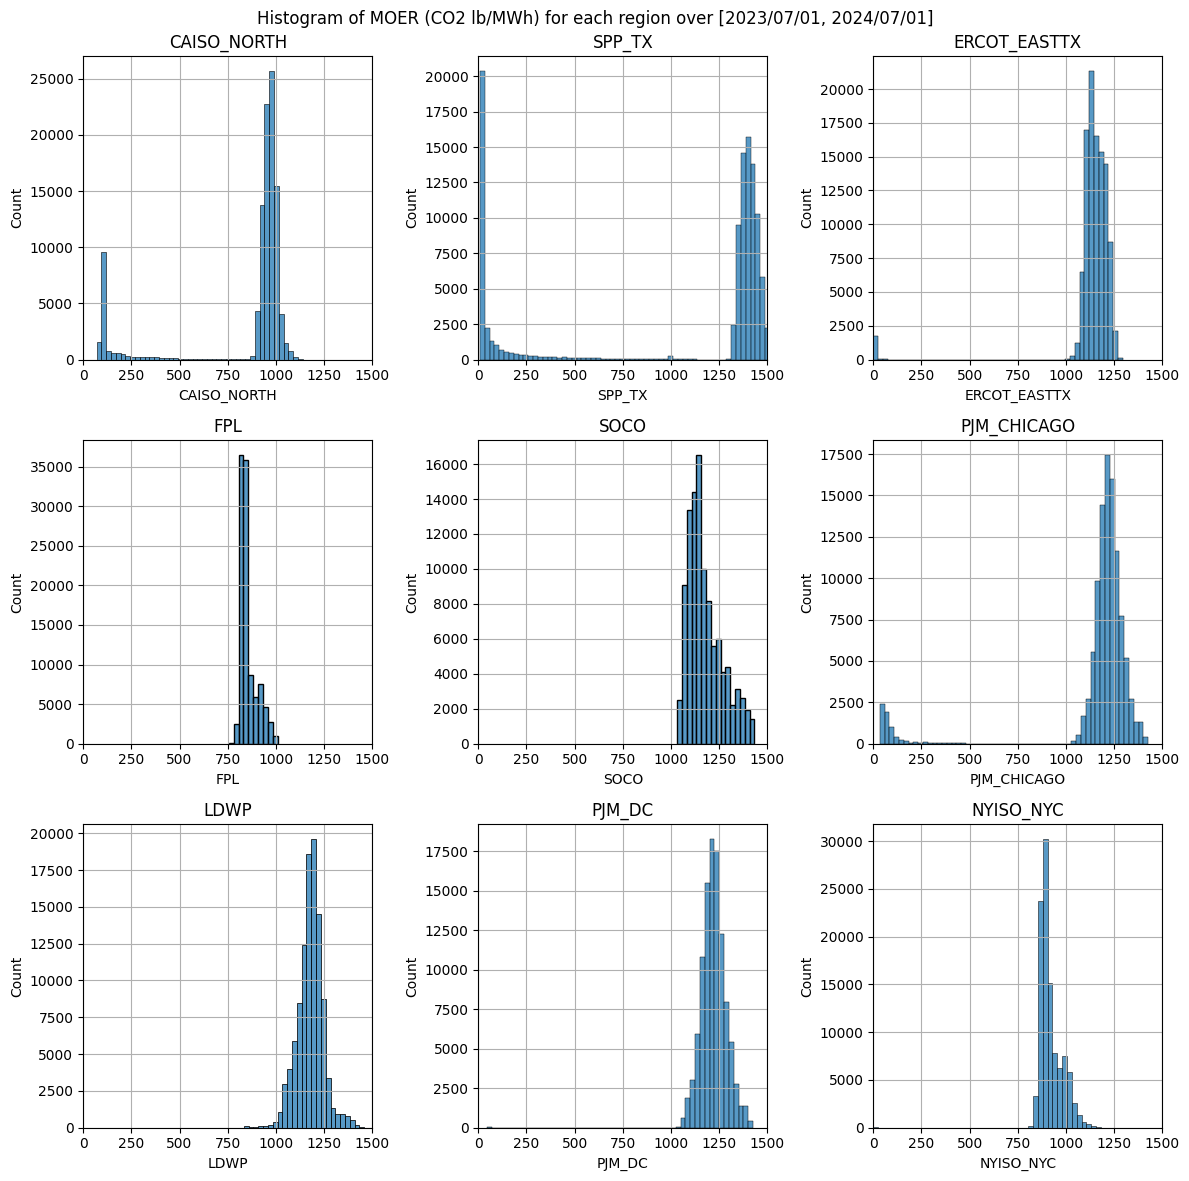

In [54]:
def plot_hist(df):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        sns.histplot(df[col], binwidth=25, ax=axes[i])
        axes[i].set_title(f"{col}")
        axes[i].set_xlim(0, 1500)
        axes[i].grid(True)

    start = df.index.min().strftime("%Y/%m/%d")
    end = df.index.max().strftime("%Y/%m/%d")
    fig.suptitle(
        f"Histogram of MOER (CO2 lb/MWh) for each region over [{start}, {end}]"
    )
    plt.tight_layout()
    plt.show()


plot_hist(df)

# Plot by time of day

In [58]:
def downsample_days(df, pct=10):
    df = df.copy()
    np.random.seed(0)
    df["date"] = df.index.date
    dates = df["date"].unique()
    pct = 10
    downsampled_dates = sorted(
        np.random.choice(dates, size=pct * len(dates) // 100, replace=False)
    )
    return df[df.date.isin(downsampled_dates)].drop(columns=["date"])


df_downsampled = downsample_days(df, pct=10)  # downsample to 10% of days

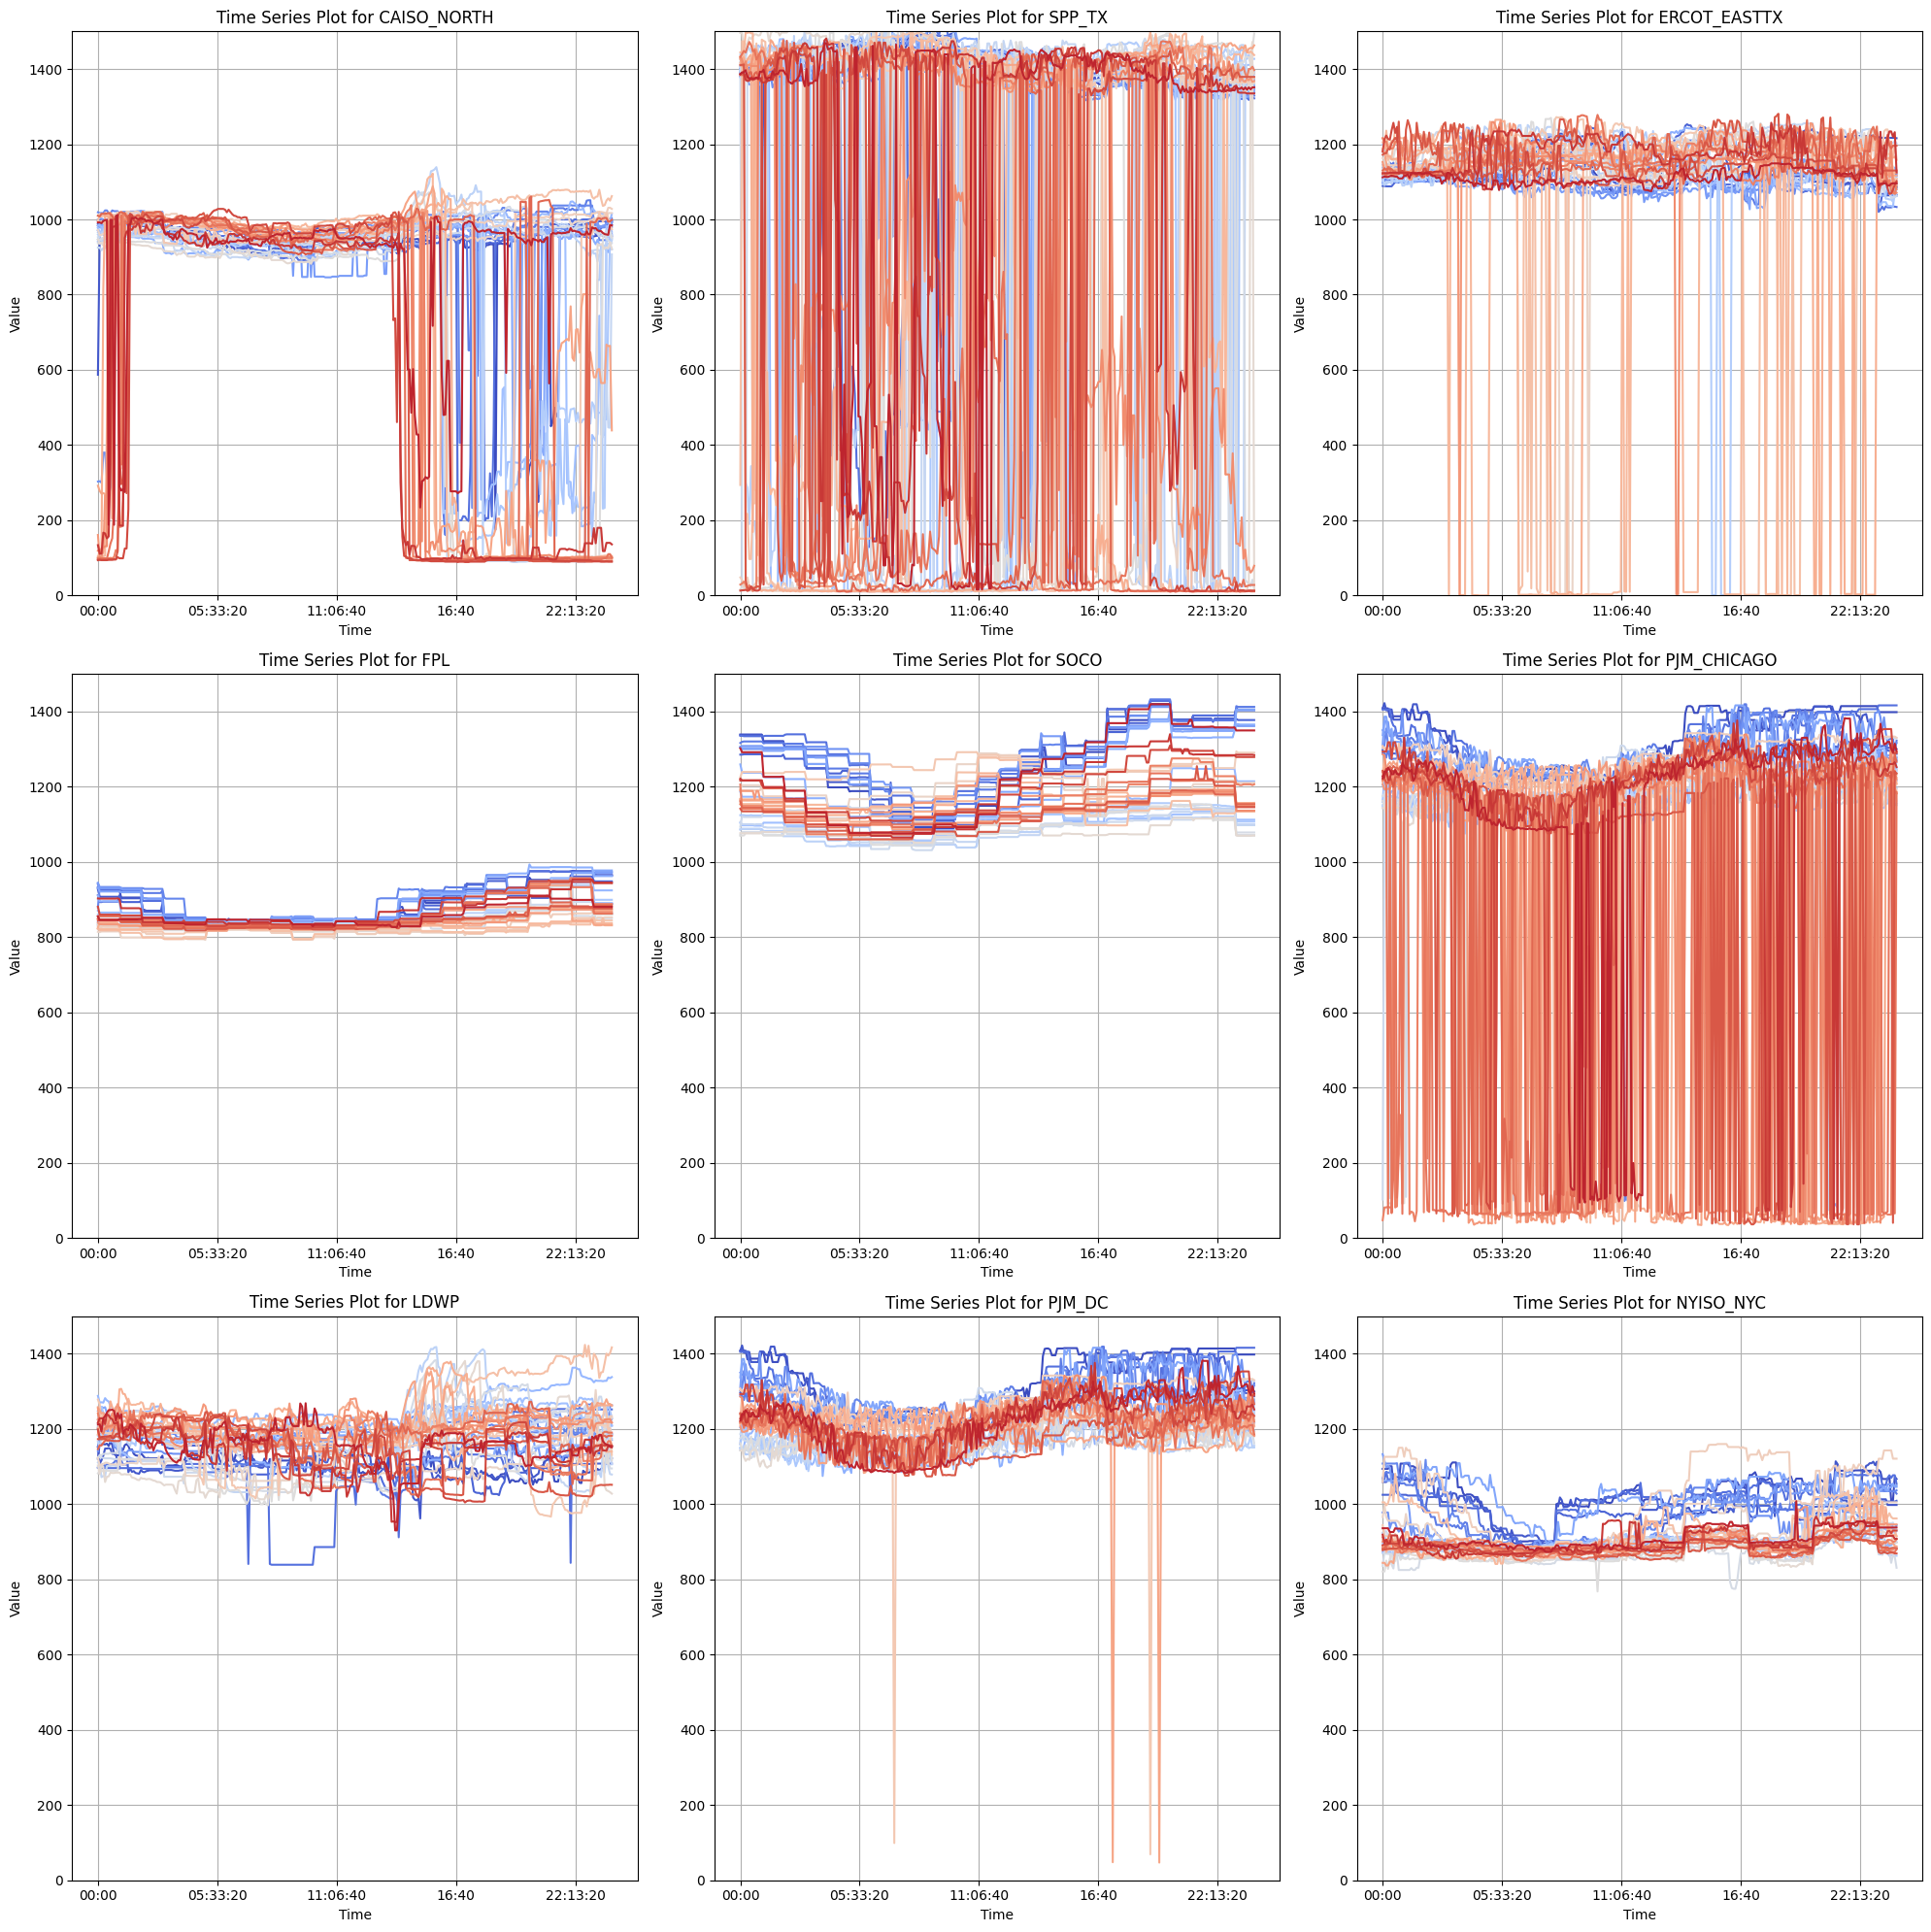

In [59]:
def make_daily_plot(df, regions):
    """
    df should have columns for regions and a datetimeindex.
    regions is a list of regions to plot.
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.flatten()

    for idx, region in enumerate(regions):
        dfr = df[[region]].copy()  # df on just a single region
        dfr["date"] = dfr.index.date
        dfr["time"] = dfr.index.time

        # Pivot to one column per day, index is time of day
        dfp = dfr.reset_index(drop=True).set_index(["time", "date"]).unstack(level=1)

        num_days = len(dfp.columns)
        cmap = plt.get_cmap("coolwarm")
        colors = [cmap(i / num_days) for i in range(num_days)]

        # Plot using the colors
        ax = axes[idx]
        dfp.plot(ax=ax, color=colors, legend=False)
        ax.set_title(f"Time Series Plot for {region}")
        ax.set_ylim(0, 1500)
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)  # Enable grid for each subplot

    plt.tight_layout()
    plt.show()


make_daily_plot(df_downsampled, regions)